# Comparison of clustering of node embeddings with a traditional community detection method


<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/community_detection/attacks_clustering_analysis.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/community_detection/attacks_clustering_analysis.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>

## Introduction

The goal of this use case is to demonstrate how node embeddings from graph convolutional neural networks trained in unsupervised manner are comparable to standard community detection methods based on graph partitioning. 

Specifically, we use unsupervised [graphSAGE](http://snap.stanford.edu/graphsage/) approach to learn node embeddings of terrorist groups in a publicly available dataset of global terrorism events, and analyse clusters of these embeddings. We compare the clusters to communities produced by [Infomap](http://www.mapequation.org), a state-of-the-art approach of graph partitioning based on information theory. 

We argue that clustering based on unsupervised graphSAGE node embeddings allow for richer representation of the data than its graph partitioning counterpart as the former takes into account node features together with the graph structure, while the latter utilises only the graph structure. 

We demonstrate, using the terrorist group dataset, that the infomap communities and the graphSAGE embedding clusters (GSEC) provide qualitatively different insights into underlying data patterns.

### Data description

__The Global Terrorism Database (GTD)__  used in this demo is available here: https://www.kaggle.com/START-UMD/gtd. GTD is an open-source database including information on terrorist attacks around the world from 1970 through 2017. The GTD includes systematic data on domestic as well as international terrorist incidents that have occurred during this time period and now includes more than 180,000 attacks. The database is maintained by researchers at the National Consortium for the Study of Terrorism and Responses to Terrorism (START), headquartered at the University of Maryland. For information refer to the initial data source: https://www.start.umd.edu/gtd/.

Full dataset contains information on more than 180,000 Terrorist Attacks.

### Glossary:
For this particular study we adopt the following terminology:

- __a community__ is a group of nodes produced by a traditional community detection algorithm (infomap community in this use case)
- __a cluster__ is a group of nodes that were clustered together using a clustering algorithm applied to node embeddings (here, [DBSCAN clustering](https://www.aaai.org/Papers/KDD/1996/KDD96-037.pdf) applied to unsupervised GraphSAGE embeddings). 


For more detailed explanation of unsupervised graphSAGE see [Unsupervised graphSAGE demo](../embeddings/graphsage-unsupervised-sampler-embeddings.ipynb).

The rest of the demo is structured as follows. First, we load the data and preprocess it (see `utils.py` for detailed steps of network and features generation). Then we apply infomap and visualise results of one selected community obtained from this method. Next, we apply unsupervised graphSAGE on the same data and extract node embeddings. We first tune DBSCAN hyperparameters, and apply DBSCAN that produces sufficient numbers of clusters with minimal number of noise points. We look at the resulting clusters, and investigate a single selected cluster in terms of the graph structure and features of the nodes in this cluster. Finally, we conclude our investigation with the summary of the results.   

In [1]:
# install StellarGraph if running on Google Colab
import sys
if 'google.colab' in sys.modules:
  %pip install -q stellargraph[demos]==1.3.0b

In [2]:
# verify that we're using the correct version of StellarGraph for this notebook
import stellargraph as sg

try:
    sg.utils.validate_notebook_version("1.3.0b")
except AttributeError:
    raise ValueError(
        f"This notebook requires StellarGraph version 1.3.0b, but a different version {sg.__version__} is installed.  Please see <https://github.com/stellargraph/stellargraph/issues/1172>."
    ) from None

In [3]:
import pandas as pd
import numpy as np
import networkx as nx
import igraph as ig

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn import preprocessing, feature_extraction, model_selection
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import random

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

%matplotlib inline

import warnings
warnings.filterwarnings('ignore') # supress warnings due to some future deprications

In [4]:
import stellargraph as sg
from stellargraph.data import EdgeSplitter
from stellargraph.mapper import GraphSAGELinkGenerator, GraphSAGENodeGenerator
from stellargraph.layer import GraphSAGE, link_classification
from stellargraph.data import UniformRandomWalk
from stellargraph.data import UnsupervisedSampler
from sklearn.model_selection import train_test_split

from tensorflow import keras

from stellargraph import globalvar

In [5]:
import mplleaflet
from itertools import count

In [6]:
import utils

### Data loading

This is the raw data of terrorist attacks that we use as a starting point of our analysis. 

In [7]:
dt_raw = pd.read_csv(
    "~/data/globalterrorismdb_0718dist.csv",
    sep=",",
    engine="python",
    encoding="ISO-8859-1",
)

### Loading preprocessed features

The resulting feature set is the aggregation of features for each of the terrorist groups (`gname`). We collect such features as total number of attacks per terrorist group, number of perpetrators etc. We use `targettype` and `attacktype` (number of attacks/targets of particular type) and transform it to a wide representation of data (e.g each type is a separate column with the counts for each group). Refer to `utils.py` for more detailed steps of the preprocessing and data cleaning.

In [8]:
gnames_features = utils.load_features(input_data=dt_raw)

In [9]:
gnames_features.head()

,gname,n_attacks,n_nperp,n_nkil,n_nwound,success_ratio,Armed Assault,Assassination,Bombing/Explosion,Facility/Infrastructure Attack,...,Other,Police,Private Citizens & Property,Religious Figures/Institutions,Telecommunication,Terrorists/Non-State Militia,Tourists,Transportation,Utilities,Violent Political Party
0,1 May,10,3.0,2.0,0.0,0.9,0.0,4.0,6.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,14 K Triad,4,24.0,0.0,0.0,1.0,0.0,0.0,4.0,0.0,...,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,14 March Coalition,1,0.0,5.0,80.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,14th of December Command,3,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
4,15th of September Liberation Legion,1,9.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Edgelist creation

The raw dataset contains information for the terrotist attacks. It contains information about some incidents being related. However, the resulting graph is very sparse. Therefore, we create our own schema for the graph, where two terrorist groups are connected, if they had at least one terrorist attack in the same country and in the same decade. To this end we proceed as follows:

-  we group the event data  by `gname` - the names of the terrorist organisations.
-  we create a new feature `decade` based on `iyear`, where one bin consists of 10 years (attacks of 70s, 80s, and so on). 
-  we add the concatination of of the decade and the country of the attack: `country_decade` which will become a link between two terrorist groups.
-  finally, we create an edgelist, where two terrorist groups are linked if they have operated in the same country in the same decade. Edges are undirected.

In addition, some edges are created based on the column `related` in the raw event data. The description of the data does not go into details how these incidents were related.  We utilise this information creating a link for terrorist groups if the terrorist attacks performed by these groups were related. If related events corresponded to the same terrorist group, they were discarded (we don't use self-loops in the graph). However, the majority of such links are already covered by `country_decade` edge type. Refer to `utils.py` for more information on graph creation.

In [10]:
G = utils.load_network(input_data=dt_raw)

In [11]:
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 3490
Number of edges: 106903
Average degree:  61.2625


### Connected components of the network

Note that the graph is disconnected, consisting of 21 connected components. 

In [12]:
print(nx.number_connected_components(G))

21


Get the sizes of the connected components:

In [13]:
Gcc = sorted(nx.connected_component_subgraphs(G), key=len, reverse=True)
cc_sizes = []
for cc in list(Gcc):
    cc_sizes.append(len(cc.nodes()))
print(cc_sizes)

[3435, 7, 6, 5, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]


The distribution of connected components' sizes shows that there is a single large component, and a few isolated groups. We expect the community detection/node embedding clustering algorithms discussed below to discover non-trivial communities that are not simply the connected components of the graph.

## Traditional community detection

We perform traditional community detection via `infomap` implemented in `igraph`. We translate the original `networkx` graph object to `igraph`, apply `infomap` to it to detect communities, and assign the resulting community memberships back to the `networkx` graph.

In [14]:
# translate the object into igraph
g_ig = ig.Graph.Adjacency(
    (nx.to_numpy_matrix(G) > 0).tolist(), mode=ig.ADJ_UNDIRECTED
)  # convert via adjacency matrix
g_ig.summary()

'IGRAPH U--- 3490 106903 -- '

In [15]:
# perform community detection
random.seed(123)
c_infomap = g_ig.community_infomap()
print(c_infomap.summary())

Clustering with 3490 elements and 160 clusters


We get 160 communities, meaning that the largest connected components of the graph are partitioned into more granular groups.

<BarContainer object of 160 artists>

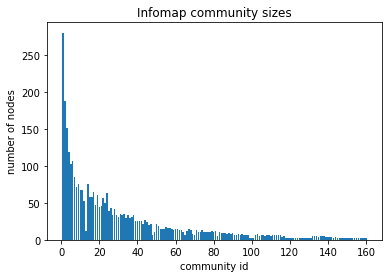

In [16]:
# plot the community sizes
infomap_sizes = c_infomap.sizes()
plt.title("Infomap community sizes")
plt.xlabel("community id")
plt.ylabel("number of nodes")
plt.bar(list(range(1, len(infomap_sizes) + 1)), infomap_sizes)

In [17]:
# Modularity metric for infomap
c_infomap.modularity

0.6287979581321445

The discovered infomap communities have smooth distribution of cluster sizes, which indicates that the underlying graph structure has a natural partitioning. The modularity score is also pretty high indicating that nodes are more tightly connected within clusters than expected from random graph, i.e., the discovered communities are tightly-knit. 

In [18]:
# assign community membership results back to networkx, keep the dictionary for later comparisons with the clustering
infomap_com_dict = dict(zip(list(G.nodes()), c_infomap.membership))
nx.set_node_attributes(G, infomap_com_dict, "c_infomap")

### Visualisation of the infomap communities

We can visualise the resulting communities using maps as the constructed network is based partially on the geolocation. The raw data have a lat-lon coordinates for each of the attacks. Terrorist groups might perform attacks in different locations. However, currently the simplified assumption is made, and the average of latitude and longitude for each terrorist group is calculated. Note that it might result in some positions being "off", but it is good enough to provide a glimpse whether the communities are consistent with the location of that groups. 

In [19]:
# fill NA based on the country name
dt_raw.latitude[
    dt_raw["gname"] == "19th of July Christian Resistance Brigade"
] = 12.136389
dt_raw.longitude[
    dt_raw["gname"] == "19th of July Christian Resistance Brigade"
] = -86.251389

# filter only groups that are present in a graph
dt_filtered = dt_raw[dt_raw["gname"].isin(list(G.nodes()))]

# collect averages of latitude and longitude for each of gnames
avg_coords = dt_filtered.groupby("gname")[["latitude", "longitude"]].mean()

print(avg_coords.shape)
print(len(G.nodes()))

(3490, 2)
3490


As plotting the whole graph is not feasible, we investigate a single community

__Specify community id in the range of infomap total number of clusters__ (`len(infomap_sizes)`)

In [20]:
com_id = 50  # smaller number - larger community, as it's sorted

In [21]:
# extraction of a subgraph from the nodes in this community
com_G = G.subgraph(
    [n for n, attrdict in G.nodes.items() if attrdict["c_infomap"] == com_id]
)
print(nx.info(com_G))

Name: 
Type: Graph
Number of nodes: 18
Number of edges: 103
Average degree:  11.4444


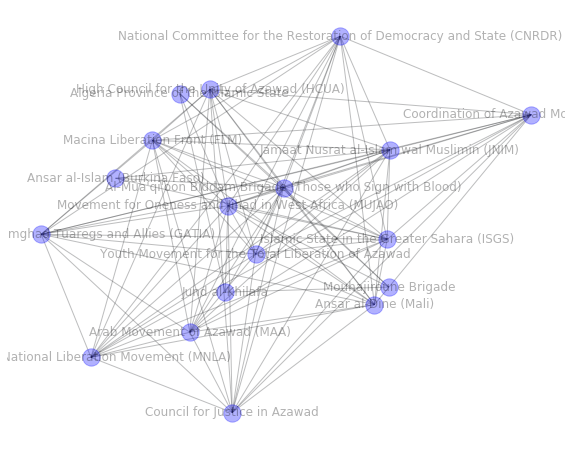

In [22]:
# plot community structure only
pos = nx.random_layout(com_G, seed=123)
plt.figure(figsize=(10, 8))
nx.draw_networkx(com_G, pos, edge_color="#26282b", node_color="blue", alpha=0.3)
plt.axis("off")
plt.show()

In [23]:
# plot on the map
nodes = com_G.nodes()
com_avg_coords = avg_coords[avg_coords.index.isin(list(nodes))]
com_avg_coords.fillna(
    com_avg_coords.mean(), inplace=True
)  # fill missing values with the average
new_order = [1, 0]
com_avg_coords = com_avg_coords[com_avg_coords.columns[new_order]]
pos = com_avg_coords.T.to_dict("list")  # layout is based on the provided coordindates


fig, ax = plt.subplots(figsize=(12, 6))
nx.draw_networkx_edges(com_G, pos, edge_color="grey")
nx.draw_networkx_nodes(com_G, pos, nodelist=nodes, node_size=200, alpha=0.5)
nx.draw_networkx_labels(com_G, pos, font_color="#362626", font_size=50)
mplleaflet.display(fig=ax.figure)

(**N.B.:** the above interactive plot will only appear after running the cell, and is not rendered in GitHub!)

### Summary of results based on infomap

Infomap is a robust community detection algorithm, and shows good results that are in line with the expectations. Most of the communities are tightly connected and reflect the geographical position of the events of the terrorist groups. That is because the graph schema is expressed as 
> _two terrorist groups are connected if they have terrorist events in the same country in the same decade_. 

However, no node features are taken into account in the case of the traditional community detection.

Next, we explore the GSEC approach, where node features are used along with the graph structure. 

## Node represenatation learning with unsupervised graphSAGE

Now we apply unsupervised GraphSAGE that takes into account node features as well as graph structure, to produce *node embeddings*. In our case, similarity of node embeddings depicts similarity of the terrorist groups in terms of their operations, targets and attack types (node features) as well as in terms of time and place of attacks (graph structure).

In [24]:
# we reload the graph to get rid of assigned attributes
G = utils.load_network(input_data=dt_raw)  # to make sure that graph is clean

# filter features to contain only gnames that are among nodes of the network
filtered_features = gnames_features[gnames_features["gname"].isin(list(G.nodes()))]
filtered_features.set_index("gname", inplace=True)
filtered_features.shape

(3490, 34)

In [25]:
filtered_features.head()  # take a glimpse at the feature data

,n_attacks,n_nperp,n_nkil,n_nwound,success_ratio,Armed Assault,Assassination,Bombing/Explosion,Facility/Infrastructure Attack,Hijacking,...,Other,Police,Private Citizens & Property,Religious Figures/Institutions,Telecommunication,Terrorists/Non-State Militia,Tourists,Transportation,Utilities,Violent Political Party
gname,,,,,,,,,,,,,,,,,,,,,
1 May,10,3.0,2.0,0.0,0.9,0.0,4.0,6.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14 March Coalition,1,0.0,5.0,80.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14th of December Command,3,0.0,0.0,0.0,1.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0
15th of September Liberation Legion,1,9.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16 January Organization for the Liberation of Tripoli,24,0.0,1.0,32.0,1.0,20.0,0.0,4.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


We perform a log-transform of the feature set to rescale feature values. 

In [26]:
# transforming features to be on log scale
node_features = filtered_features.transform(lambda x: np.log1p(x))

In [27]:
# sanity check that there are no misspelled gnames left
set(list(G.nodes())) - set(list(node_features.index.values))

set()

### Unsupervised graphSAGE

(For a detailed unsupervised GraphSAGE workflow with a narrative, see [Unsupervised graphSAGE demo](../embeddings/graphsage-unsupervised-sampler-embeddings.ipynb))

In [28]:
Gs = sg.StellarGraph.from_networkx(G, node_features=node_features)
print(Gs.info())

NetworkXStellarGraph: Undirected multigraph
 Nodes: 3490, Edges: 106903

 Node types:
  default: [3490]
    Edge types: default-default->default

 Edge types:
    default-default->default: [106903]



In [29]:
# parameter specification
number_of_walks = 3
length = 5
batch_size = 50
epochs = 10
num_samples = [20, 20]
layer_sizes = [100, 100]
learning_rate = 1e-2

In [30]:
unsupervisedSamples = UnsupervisedSampler(
    Gs, nodes=G.nodes(), length=length, number_of_walks=number_of_walks
)

In [31]:
generator = GraphSAGELinkGenerator(Gs, batch_size, num_samples)
train_gen = generator.flow(unsupervisedSamples)

In [32]:
assert len(layer_sizes) == len(num_samples)

graphsage = GraphSAGE(
    layer_sizes=layer_sizes, generator=generator, bias=True, dropout=0.0, normalize="l2"
)

We now build a Keras model from the GraphSAGE class that we can use for unsupervised predictions. We add a `link_classfication` layer as unsupervised training operates on node pairs.

In [33]:
x_inp, x_out = graphsage.in_out_tensors()

prediction = link_classification(
    output_dim=1, output_act="sigmoid", edge_embedding_method="ip"
)(x_out)

link_classification: using 'ip' method to combine node embeddings into edge embeddings


In [34]:
model = keras.Model(inputs=x_inp, outputs=prediction)

model.compile(
    optimizer=keras.optimizers.Adam(lr=learning_rate),
    loss=keras.losses.binary_crossentropy,
    metrics=[keras.metrics.binary_accuracy],
)

In [35]:
history = model.fit(
    train_gen,
    epochs=epochs,
    verbose=2,
    use_multiprocessing=False,
    workers=1,
    shuffle=True,
)

Epoch 1/10
1676/1676 - 602s - loss: 0.5891 - binary_accuracy: 0.7083
Epoch 2/10
1676/1676 - 631s - loss: 0.5779 - binary_accuracy: 0.7310
Epoch 3/10
1676/1676 - 618s - loss: 0.5753 - binary_accuracy: 0.7361
Epoch 4/10
1676/1676 - 619s - loss: 0.5742 - binary_accuracy: 0.7372
Epoch 5/10
1676/1676 - 604s - loss: 0.5740 - binary_accuracy: 0.7384
Epoch 6/10
1676/1676 - 587s - loss: 0.5736 - binary_accuracy: 0.7409
Epoch 7/10
1676/1676 - 573s - loss: 0.5725 - binary_accuracy: 0.7426
Epoch 8/10
1676/1676 - 573s - loss: 0.5707 - binary_accuracy: 0.7429
Epoch 9/10
1676/1676 - 575s - loss: 0.5740 - binary_accuracy: 0.7361
Epoch 10/10
1676/1676 - 586s - loss: 0.5719 - binary_accuracy: 0.7382


### Extracting node embeddings

In [36]:
node_ids = list(Gs.nodes())
node_gen = GraphSAGENodeGenerator(Gs, batch_size, num_samples).flow(node_ids)

In [37]:
embedding_model = keras.Model(inputs=x_inp[::2], outputs=x_out[0])

In [38]:
node_embeddings = embedding_model.predict(node_gen, workers=4, verbose=1)

70/70 [==============================] - 10s 142ms/step


#### 2D t-sne plot of the resulting node embeddings

Here we visually check whether embeddings have some underlying cluster structure.

In [39]:
node_embeddings.shape

(3490, 100)

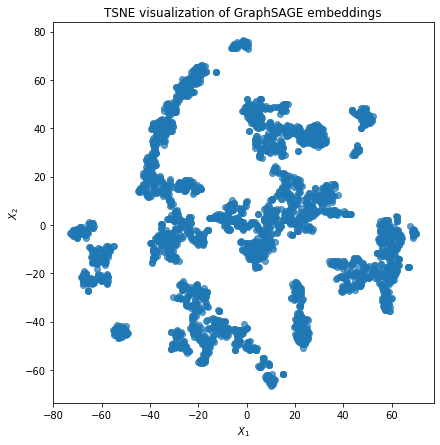

In [40]:
# TSNE visualisation to check whether the embeddings have some structure:
X = node_embeddings
if X.shape[1] > 2:
    transform = TSNE  # PCA

    trans = transform(n_components=2, random_state=123)
    emb_transformed = pd.DataFrame(trans.fit_transform(X), index=node_ids)
else:
    emb_transformed = pd.DataFrame(X, index=node_ids)
    emb_transformed = emb_transformed.rename(columns={"0": 0, "1": 1})

alpha = 0.7

fig, ax = plt.subplots(figsize=(7, 7))
ax.scatter(emb_transformed[0], emb_transformed[1], alpha=alpha)
ax.set(aspect="equal", xlabel="$X_1$", ylabel="$X_2$")
plt.title("{} visualization of GraphSAGE embeddings".format(transform.__name__))
plt.show()

#### t-sne colored by infomap
We also depict the same t-sne plot colored by infomap communities. As we can observe t-sne of GraphSAGE embeddings do not really separate the infomap communities.

Text(0.5, 1.0, 't-sne with colors corresponding to infomap communities')

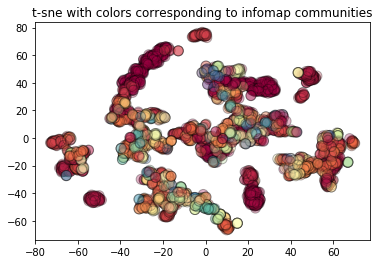

In [41]:
emb_transformed["infomap_clusters"] = emb_transformed.index.map(infomap_com_dict)
plt.scatter(
    emb_transformed[0],
    emb_transformed[1],
    c=emb_transformed["infomap_clusters"],
    cmap="Spectral",
    edgecolors="black",
    alpha=0.3,
    s=100,
)
plt.title("t-sne with colors corresponding to infomap communities")

Next, we apply dbscan algorithm to cluster the embeddings. dbscan has two hyperparameters: `eps` and `min_samples`, and produces clusters along with the noise points (the points that could not be assigned to any particular cluster, indicated as -1). These tunable parameters directly affect the cluster results. We use greedy search over the hyperparameters and check what are the good candidates.

eps:0.1
eps:0.2
eps:0.30000000000000004
eps:0.4
eps:0.5
eps:0.6
eps:0.7000000000000001
eps:0.8


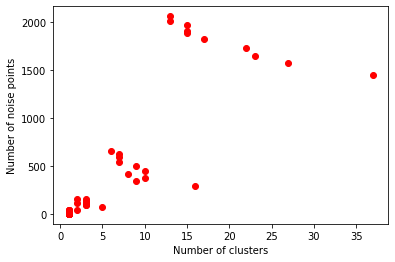

In [42]:
db_dt = utils.dbscan_hyperparameters(
    node_embeddings, e_lower=0.1, e_upper=0.9, m_lower=5, m_upper=15
)

In [43]:
# print results where there are more clusters than 1, and sort by the number of noise points
db_dt.sort_values(by=["n_noise"])[db_dt.n_clusters > 1]

,n_clusters,n_noise,eps,min_samples
35,2,38,0.4,10
20,5,71,0.3,5
21,3,91,0.3,6
22,3,94,0.3,7
23,3,102,0.3,8
24,2,117,0.3,9
25,3,124,0.3,10
26,3,129,0.3,11
27,3,138,0.3,12
28,2,151,0.3,13


Pick the hyperparameters, where the clustering results have as little noise points as possible, but also create number of clusters of reasonable size.

In [44]:
# perform dbscan with the chosen parameters:
db = DBSCAN(eps=0.1, min_samples=5).fit(node_embeddings)

Calculating the clustering statistics:

In [45]:
labels = db.labels_
# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)
print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
print("Silhouette Coefficient: %0.3f" % metrics.silhouette_score(node_embeddings, labels))

Estimated number of clusters: 37
Estimated number of noise points: 1450
Silhouette Coefficient: -0.054


We plot t-sne again but with the colours corresponding to dbscan points. 

Text(0.5, 1.0, 't-sne with colors corresponding to dbscan cluster. Without noise points')

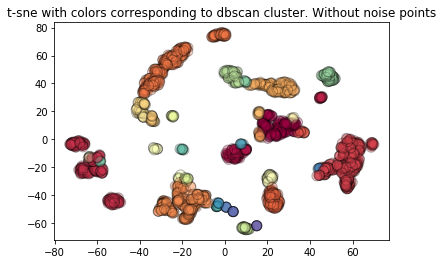

In [46]:
emb_transformed["dbacan_clusters"] = labels
X = emb_transformed[emb_transformed["dbacan_clusters"] != -1]


plt.scatter(
    X[0],
    X[1],
    c=X["dbacan_clusters"],
    cmap="Spectral",
    edgecolors="black",
    alpha=0.3,
    s=100,
)
plt.title("t-sne with colors corresponding to dbscan cluster. Without noise points")

### Investigating GSEC and infomap qualitative differences

Let's take a look at the resulting GSEC clusters, and explore, as an example, one particular cluster of a reasonable size, which is not a subset of any single infomap community. 

Display cluster sizes for first 15 largest clusters:

In [47]:
clustered_df = pd.DataFrame(node_embeddings, index=node_ids)
clustered_df["cluster"] = db.labels_
clustered_df.groupby("cluster").count()[0].sort_values(ascending=False)[0:15]

cluster
-1     1450
 4      337
 8      304
 9      255
 3      230
 0      142
 11     138
 7      106
 1       80
 24      70
 26      67
 18      39
 23      32
 15      31
 13      22
Name: 0, dtype: int64

We want to display clusters that differ from infomap communities, as they are more interesting in this context. Therefore we calculate for each DBSCAN cluster how many different infomap communities it contains. The results are displayed below.

In [48]:
inf_db_cm = clustered_df[["cluster"]]
inf_db_cm["infomap"] = inf_db_cm.index.map(infomap_com_dict)
dbscan_different = inf_db_cm.groupby("cluster")[
    "infomap"
].nunique()  # if 1 all belong to same infomap cluster
# show only those clusters that are not the same as infomap
dbscan_different[dbscan_different != 1]

cluster
-1     150
 0      18
 1       3
 3       9
 4      17
 5       2
 8       4
 9      16
 10      4
 11      3
 12      5
 13      3
 14      4
 15      2
 17      3
 19      2
 20      2
 22      3
 24      9
 25      2
 28      3
 30      3
 31      2
Name: infomap, dtype: int64

For example, DBSCAN `cluster_12` has nodes that were assigned to 2 different infomap clusters, while `cluster_31` has nodes from 8 different infomap communities.  

### Single cluster visualisation

Now that we've selected a GSEC cluster (id=20) of reasonable size that contains nodes belonging to 4 different infomap communities, let's explore it.

__To visualise a particular cluster, specify its number here:__

In [49]:
# specify the cluster id here:
cluster_id = 20

In [50]:
# manually look at the terrorist group names
list(clustered_df.index[clustered_df.cluster == cluster_id])

['Supporters of Muse Sudi Yalahow',
 'Jemaah Islamiya (JI)',
 'Bangsamoro Islamic Freedom Movement (BIFM)',
 'Magahat Militia',
 'National Democratic Front-Bicol (NDF-Bicol)']

In [51]:
# create a subgraph from the nodes in the cluster
cluster_G = G.subgraph(list(clustered_df.index[clustered_df.cluster == cluster_id]))

List for each of the `gname` (terrorist group name) in the cluster the assigned infomap community id. This shows whether the similar community was produced by infomap or not.

In [52]:
comparison = {
    k: v
    for k, v in infomap_com_dict.items()
    if k in list(clustered_df.index[clustered_df.cluster == cluster_id])
}
comparison

{'Supporters of Muse Sudi Yalahow': 23,
 'Jemaah Islamiya (JI)': 21,
 'Bangsamoro Islamic Freedom Movement (BIFM)': 21,
 'Magahat Militia': 21,
 'National Democratic Front-Bicol (NDF-Bicol)': 21}

As another metric of clustering quality, we display how many edges are inside this cluster vs how many nodes are going outside (only one of edge endpoints is inside a cluster)

In [53]:
external_internal_edges = utils.cluster_external_internal_edges(G, inf_db_cm, "cluster")

In [54]:
external_internal_edges[external_internal_edges.cluster == cluster_id]

,cluster,nexternal_edges,ninternal_edges,ratio
14,20,136,6,0.044118


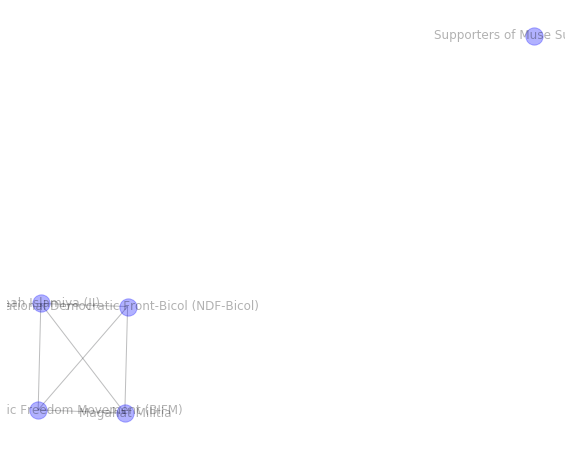

In [55]:
# plot the structure only
pos = nx.fruchterman_reingold_layout(cluster_G, seed=123, iterations=30)
plt.figure(figsize=(10, 8))
nx.draw_networkx(cluster_G, pos, edge_color="#26282b", node_color="blue", alpha=0.3)
plt.axis("off")
plt.show()

Recall that terrorist groups (nodes) are connected, when at least one of the attacks was performed in the same decade in the same country. Therefore the connectivity indicates spatio-temporal similarity.   

There are quite a few clusters that are similar to infomap clusters. We pick a cluster that is not a subset of any single infomap community. We can see that there are disconnected groups of nodes in this cluster. 

So why are these disconnected components combined into one cluster? GraphSAGE embeddings directly depend on both node features and an underlying graph structure. Therefore, it makes sense to investigate similarity of features of the nodes in the cluster. It can highlight why these terrorist groups are combined together by GSEC.

In [56]:
cluster_feats = filtered_features[
    filtered_features.index.isin(
        list(clustered_df.index[clustered_df.cluster == cluster_id])
    )
]
# show only non-zero columns
features_nonzero = cluster_feats.loc[:, (cluster_feats != 0).any()]
features_nonzero.style.background_gradient(cmap="RdYlGn_r")

,n_attacks,n_nperp,n_nkil,n_nwound,success_ratio,Armed Assault,Assassination,Bombing/Explosion,Facility/Infrastructure Attack,Hostage Taking (Barricade Incident),Hostage Taking (Kidnapping),Airports & Aircraft,Business,Educational Institution,Food or Water Supply,Government (Diplomatic),Government (General),Journalists & Media,Military,Police,Private Citizens & Property,Religious Figures/Institutions,Tourists,Transportation,Utilities
gname,,,,,,,,,,,,,,,,,,,,,,,,,
Bangsamoro Islamic Freedom Movement (BIFM),391,2815,288,720,0.777494,131,7,218,11,1,9,0,23,4,1,0,16,1,206,20,47,4,0,8,23
Jemaah Islamiya (JI),76,29,341,1195,0.763158,2,1,73,0,0,0,1,8,0,0,3,4,0,1,2,8,38,2,5,1
Magahat Militia,2,0,3,0,1,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0
National Democratic Front-Bicol (NDF-Bicol),3,3,2,0,1,1,0,0,1,0,1,0,1,0,0,0,0,0,2,0,0,0,0,0,0
Supporters of Muse Sudi Yalahow,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


We can see that most of the isolated nodes in the cluster have features similar to those in the tight clique, e.g., in most cases they have high number of attacks, high success ratio, and attacks being focused mostly on bombings, and their targets are often the police. 

Note that there are terrorist groups that differ from the rest of the groups in the cluster in terms of their features. By taking a closer look we can observe that these terrorist groups are a part of a tight clique. For example, _Martyr al-Nimr Battalion_ has number of bombings equal to 0, but it is a part of a fully connected subgraph. 

Interestingly, _Al-Qaida in Saudi Arabia_ ends up in the same cluster as _Al-Qaida in Yemen_, though they are not connected directly in the network.    

Thus we can observe that clustering on GraphSAGE embeddings combines groups based both on the underlying structure as well as features. 

In [57]:
nodes = cluster_G.nodes()
com_avg_coords = avg_coords[avg_coords.index.isin(list(nodes))]
new_order = [1, 0]
com_avg_coords = com_avg_coords[com_avg_coords.columns[new_order]]
com_avg_coords.fillna(
    com_avg_coords.mean(), inplace=True
)  # fill missing values with the average
pos = com_avg_coords.T.to_dict("list")  # layout is based on the provided coordindates

fig, ax = plt.subplots(figsize=(22, 12))

nx.draw_networkx_nodes(cluster_G, pos, nodelist=nodes, node_size=200, alpha=0.5)
nx.draw_networkx_labels(cluster_G, pos, font_color="red", font_size=50)
nx.draw_networkx_edges(cluster_G, pos, edge_color="grey")

mplleaflet.display(fig=ax.figure)

(**N.B.:** the above interactive plot will only appear after running the cell, and is not rendered in GitHub!)

These groups are also very closely located, but in contrast with infomap, this is not the only thing that defines the clustering groups.

#### GSEC results

What we can see from the results above is a somehow different picture from the infomap (note that by rerunning this notebook, the results might change due to the nature of the GraphSAGE predictions). Some clusters are identical to the infomap, showing that GSEC __capture__ the network structure. But some of the clusters differ - they are not necessary connected. By observing the feature table we can see that it has terrorist groups with __similar characteristics__. 

## Conclusion

In this use case we demonstrated the conceptual differences of traditional community detection and unsupervised GraphSAGE embeddings clustering (GSEC) on a real dataset. We can observe that the traditional approach to the community detection via graph partitioning produces communities that are related to the graph structure only, while GSEC combines the features and the structure. However, in the latter case we should be very conscious of the network schema and the features, as these significantly affect both the clustering and the interpretation of the resulting clusters. 

For example, if we don't want the clusters where neither number of kills nor country play a role, we might want to exclude `nkills` from the feature set, and create a graph, where groups are connected only via the decade, and not via country. Then, the resulting groups would probably be related to the terrorist activities in time, and grouped by their similarity in their target and the types of attacks.  

<table><tr><td>Run the latest release of this notebook:</td><td><a href="https://mybinder.org/v2/gh/stellargraph/stellargraph/master?urlpath=lab/tree/demos/community_detection/attacks_clustering_analysis.ipynb" alt="Open In Binder" target="_parent"><img src="https://mybinder.org/badge_logo.svg"/></a></td><td><a href="https://colab.research.google.com/github/stellargraph/stellargraph/blob/master/demos/community_detection/attacks_clustering_analysis.ipynb" alt="Open In Colab" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg"/></a></td></tr></table>